# Transfer Learning(VGG16)+logistic regression

### Reference:
**CNN-VGG-Transfer**： [link](http://enric.hosting.nyu.edu/notebooks/CNN-VGG-Transfer)

In [1]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

In [2]:
from torchsummary import summary

summary(vgg16, input_size=(3,224,224))

D:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

We start by loading the data:

In [3]:
import os
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# data_dir = './sample'
# data_dir = './coverimage_del'
# data_dir = './IMAGES_NEW'
data_dir = './dataset_whole_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val','test']}
dataloaders    = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val','test']}
dataset_sizes  = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names    = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's show a couple of these pictures, not a pretty sight!

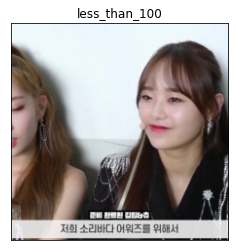

In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title=None):
    inp  = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.gca().set(xticks=[],yticks=[])

# Plot a random training image
image, label = next(iter(dataloaders['train']))
show_image(image[0], title=class_names[label])

In [5]:
# Load the original pre-trained model
vgg16 = models.vgg16(pretrained=True).eval()

In [6]:
# We register a function which records the input to the last layer
# this is a 4096 x 1 dimensional vector
activations = []
def get_activation(self, i_data, o_data):    
    activations.append(i_data)

vgg16.classifier[-1].register_forward_hook(get_activation);

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def record_features(dataloader):
    y = []
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # loop through the data loader
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if(i%30 ==0):
                print(i)
            
            # running the network will add its activation
            # to the activations array
            output      = vgg16(inputs)
            
            y.append(labels)
    return y

y_tr = record_features(dataloaders['train'])
y_tr = np.concatenate([y.detach().numpy() for y in y_tr])
X_tr = np.array([ a[0][0].detach().numpy() for a in activations])

activations = []
y_te = record_features(dataloaders['val'])
y_te = np.concatenate([y.detach().numpy() for y in y_te])
X_te = np.array([ a[0][0].detach().numpy() for a in activations])

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050
4080
4110
4140
4170
4200
4230
4260
4290
4320
4350
4380
4410
4440
4470
4500
4530
4560
4590
4620
4650
4680
4710
4740
4770
4800
4830
4860
4890
4920
4950
4980
5010
5040
5070
5100
5130
5160
5190
5220
5250
5280
5310
5340
5370
5400
5430
5460
5490
5520
5550
5580
5610
5640
5670
5700
5730
5760
5790
5820
5850
5880
5910
5940
5970
6000
6030
6060
6090
6120
6150
6180
6210

In [ ]:
activations

In [19]:
activations = []
y_test = record_features(dataloaders['test'])
y_test = np.concatenate([y.detach().numpy() for y in y_test])
X_test = np.array([ a[0][0].detach().numpy() for a in activations])

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model = model.fit(X_tr,y_tr)
y_tr_hat = model.predict(X_tr)
y_te_hat = model.predict(X_te)
y_test_hat = model.predict(X_test)


print(f"Train accuracy: {accuracy_score(y_tr_hat,y_tr)*100:.2f}%%")
print(f"Val accuracy: {accuracy_score(y_te_hat,y_te)*100:.2f}%%")
print(f"Test accuracy: {accuracy_score(y_test_hat,y_test)*100:.2f}%%")

Train accuracy: 99.84%%
Val accuracy: 20.39%%
Test accuracy: 21.49%%


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model predicts that this belongs to ... more_than_500000


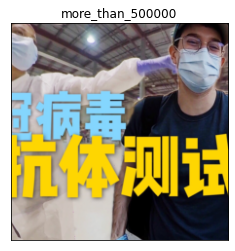

In [29]:
activations = []

# class prediction for our model
def predict(image):
    
    # run the network to obtain the activation
    with torch.no_grad():
        vgg16(image)
    
    # run the activation through the sklearn model
    X_act = activations[0][0].detach().numpy()
    return model.predict(X_act)[0]

# show a random test image
image, label = next(iter(dataloaders['test']))
show_image(image[0], title=class_names[label])

# perform the prediction
print(f"The model predicts that this belongs to ... {class_names[predict(image)]}")

In [26]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='black', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

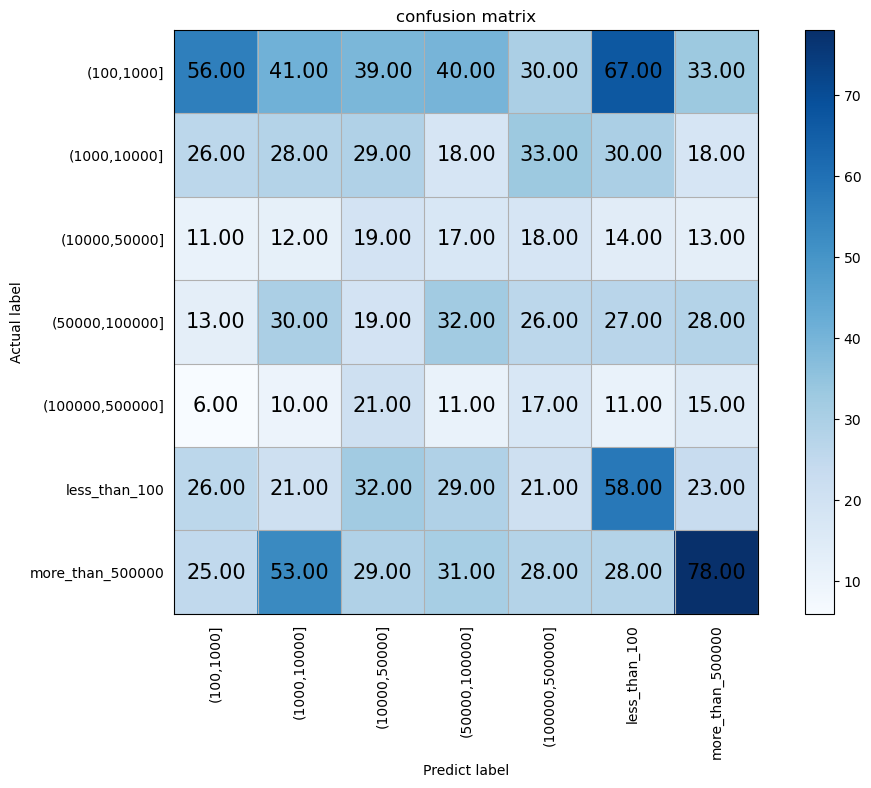

In [32]:
# classes表示不同类别的名称，比如这有6个类别
classes = [ '(100,1000]', '(1000,10000]', '(10000,50000]', '(50000,100000]', '(100000,500000]','less_than_100','more_than_500000']
y_true = y_test
y_pred  = y_test_hat
# y_true = y_te
# y_pred  = y_te_hat

 

# 获取混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, 'confusion_matrix_test.png', title='confusion matrix')